Usaremos o conjunto de dados MNIST, composto de 70 mil imagens pequenas de algarismos escritos à mão por estudantes do ensino médio e funcionários do US Census Bureau. Cada imagem é rotulada com o algarismo que a representa. Esse conjunto tem sido tão estudado que, muitas vezes, é chamado de “hello world” do aprendizado de máquina: sempre que as pessoas apresentam um novo algoritmo de classificação, elas têm curiosidade de conferir como será seu desempenho no MNIST. E sempre que alguém decide estudar aprendizado de máquina, cedo ou tarde, acaba se deparando com o MNIST.

# O código a seguir obtém o conjunto de dados do MNIST:

In [34]:
from sklearn.datasets import fetch_openml
import numpy as np

In [31]:
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

C:\Users\MAICO\anaconda3\envs\machine_imobiliario_pj1\lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
X,y = mnist["data"],mnist["target"]

In [8]:
X.shape # data,contém um array com uma linha por instância e uma coluna por característica.

(70000, 784)

In [9]:
y.shape # target, contém um array com rótulos

(70000,)

Existem 70 mil imagens e cada uma delas apresenta 784 características. Isso ocorre porque cada imagem tem 28 × 28 pixels, e cada característica representa simplesmente a intensidade de um pixel, de 0 (branco) a 255 (preto).

Vamos dar uma espiada em um algarismo do conjunto de dados. Tudo que precisa fazer é pegar o vetor da característica de uma instância, remodelá-lo em um array de 28 × 28 e exibi-lo usando a função imshow() da Matplotlib:

In [20]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [33]:
X.iloc[0]

pixel1      0.0
pixel2      0.0
pixel3      0.0
pixel4      0.0
pixel5      0.0
           ... 
pixel780    0.0
pixel781    0.0
pixel782    0.0
pixel783    0.0
pixel784    0.0
Name: 0, Length: 784, dtype: float64

<function matplotlib.pyplot.show(close=None, block=None)>

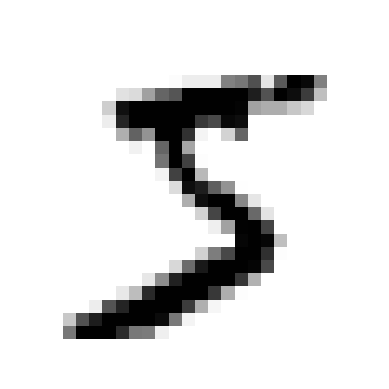

In [39]:
some_digit = np.array(X.iloc[0])
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show

In [40]:
y[0] # está como string

'5'

O algarismo parece com um 5, e é justamente isso o que o rótulo nos informa

# Convertendo os rótulos para inteiros

In [42]:
y = y.astype(np.uint8)
y[0] # convertido

5

# Conjunto de testes e treinamento

O conjunto de dados MNIST, na verdade, já está dividido em um conjunto de treinamento (as primeiras 60 mil imagens) e em um conjunto de teste (as últimas 10 mil imagens): 

In [43]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

O conjunto de treinamento já está embaralhado, o que é bom, pois isso assegura que todos os folds de validação cruzada serão semelhantes (você não quer que um fold perca alguns algarismos).

# Treinando um classificador binário

Inicialmente irei tentar identificar somente um algarismo — por exemplo, o número 5. Este “5-detector” será um exemplo de classificador binário capaz de fazer distinções entre apenas duas classes, 5 e não-5. Vamos criar os vetores-alvo para essa tarefa de classificação:

In [44]:
y_train_5 = (y_train == 5) # True pora todos os 5, False para os outros algarismos
y_test_5 = (y_test == 5)

Agora, vamos escolher um classificador e treiná-lo. Um bom ponto de partida é um classificador gradiente descendente estocástico (SGD), usando a classe SGDClassifier da Scikit-Learn.

Isso ocorre em parte porque o SGD lida com instâncias de treinamento de forma independente, uma de cada vez (o que também torna o SGD adequado para o aprendizado online).

### Ciando um SGDClassifier e treiná-lo em todo o conjunto de treinamento:

In [45]:
from sklearn.linear_model import SGDClassifier

In [46]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

O SGDClassifier depende da aleatoriedade durante o treinamento (por isso, o nome “estocástico”). Caso queira resultados que possam ser reproduzidos, defina o parâmetro random_state.

### Usando para detectar imagens do número 5: 

In [47]:
sgd_clf.predict([some_digit])

C:\Users\MAICO\anaconda3\envs\machine_imobiliario_pj1\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

O classificador estima que esta imagem representa um 5 (True). Pelo visto, ele estimou corretamente! Agora, avaliaremos o desempenho desse modelo.

# Cálculo de desempenho

## Calculando a acurácia com a validação cruzada

Usaremos a função cross_val_score() para avaliar o seu modelo SGDClassifier com o método k-fold de validação cruzada em três partes.

O método k-fold de validação cruzada significa dividir o conjunto de treinamento em k-folds (neste caso, três) e, depois, prever e avaliar as predições em cada conjunto utilizando um modelo treinado nos folds restantes

In [66]:
from sklearn.model_selection import cross_val_score

In [68]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Acurácia acima de 95% (proporção de predições corretas) em todos os folds de validação cruzada? Isso não é um espetáculo? Antes que você fique muito entusiasmado, vejamos um classificador que deixa a desejar e somente classifica todas as imagens na classe “não-5”:

In [69]:
from sklearn.base import BaseEstimator

In [77]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [79]:
# Estimando a acurácia deste modelo
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

Mais de 90% de acurácia! Isso acontece simplesmente porque apenas cerca de 10% das imagens são “5”, assim sendo, caso sempre estime que uma imagem não é um 5, terá razão em cerca de 90% das vezes.

### Conclusão:
Isso demonstra por que a acurácia geralmente não é a medida de desempenho preferida para os classificadores, sobretudo quando você está manipulando conjuntos de dados assimétricos (ou seja, quando algumas classes são muito mais frequentes que outras).

# Matriz de confusão